In [1]:
#import libraries
import yfinance as yf
import pandas as pd
import talib
from talib import abstract #conda install -c conda-forge ta-lib
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import joblib

pd.set_option('display.max_rows', 600)

In [2]:
#import yahoo stock data
data = yf.Ticker('SPY').history(start='1990-01-29') #get the yahoo stock data start from the beginning
data.columns = ['open','high','low','close','volume','dividends','split'] #renamce columns
data.head()

,open,high,low,close,volume,dividends,split
Date,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0


In [3]:
#data pre-processing of cyclical features
#this step helps classification on time-series data
#source: http://blog.davidkaleko.com/feature-engineering-cyclical-features.html
#note year is not cyclical features
data['year'] = data.index.to_series().dt.year.to_list()
data['month'] = data.index.to_series().dt.month.to_list()
data['day'] = data.index.to_series().dt.day.to_list()
data['weekday'] = data.index.to_series().dt.dayofweek.to_list()

data['month_sin'] = np.sin(data.month*(2.*np.pi/12))
data['month_cos'] = np.cos(data.month*(2.*np.pi/12))

data['day_sin'] = np.sin(data.day*(2.*np.pi/30))
data['day_cos'] = np.cos(data.day*(2.*np.pi/30))

data['weekday_sin'] = np.sin(data.weekday*(2.*np.pi/7))
data['weekday_cos'] = np.cos(data.weekday*(2.*np.pi/7))

data.head()

,open,high,low,close,volume,dividends,split,year,month,day,weekday,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos
Date,,,,,,,,,,,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0,1993,1,29,4,0.500000,0.866025,-0.207912,0.978148,-0.433884,-0.900969
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0,1993,2,1,0,0.866025,0.500000,0.207912,0.978148,0.000000,1.000000
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0,1993,2,2,1,0.866025,0.500000,0.406737,0.913545,0.781831,0.623490
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0,1993,2,3,2,0.866025,0.500000,0.587785,0.809017,0.974928,-0.222521
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0,1993,2,4,3,0.866025,0.500000,0.743145,0.669131,0.433884,-0.900969


In [4]:
#check redundant column
data.sum()

open           8.919516e+05
high           8.970880e+05
low            8.862549e+05
close          8.919869e+05
volume         6.064174e+11
dividends      7.742400e+01
split          0.000000e+00
year           1.443125e+07
month          4.680500e+04
day            1.130780e+05
weekday        1.452500e+04
month_sin     -1.563844e+01
month_cos     -1.291481e+02
day_sin        7.139944e+01
day_cos        2.877129e+01
weekday_sin    2.595125e+03
weekday_cos   -6.556680e+02
dtype: float64

In [5]:
#remove split as it contains only 0
data.drop('split', axis=1, inplace=True)

In [6]:
#compute indicators for the dataset
ind_list = talib.get_functions() #get all indicators for financial analysis

temp = data
#compute each indicator for the dataset
#source: 
for ind in ind_list:
    if ind != 'MAVP': #MAVP needs periods
        output = eval('abstract.' + ind + '(data)')
    else:
        output = eval('talib.MAVP(data.close, periods=data.index.to_series(), minperiod=2, maxperiod=30, matype=0)')
    output.name = ind.lower() if type(output) == pd.core.series.Series else None #rename for 1D output
    temp = pd.merge(temp, pd.DataFrame(output), 
                    left_on = temp.index, 
                    right_on = output.index).set_index('key_0') #merge output with original data
ind_data = temp
ind_data.head()

,open,high,low,close,volume,dividends,year,month,day,weekday,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,1993,1,29,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.165714e+05,NaN,1003200.0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,1993,2,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.183502,1.197071e+06,NaN,1483700.0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,1993,2,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0.146798,1.348046e+06,NaN,1685000.0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,1993,2,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0.293601,1.806860e+06,NaN,2214400.0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,1993,2,4,3,...,NaN,0.226824,NaN,0.051449,NaN,NaN,0.366995,2.178910e+06,NaN,2745900.0


In [7]:
#check null
ind_data.isnull().sum().describe()

count     191.000000
mean       85.460733
std       733.043746
min         0.000000
25%         0.000000
50%         0.000000
75%        14.000000
max      7191.000000
dtype: float64

In [8]:
#remove column that has a lot of null (3% of the sample number)
#otherwise replace null by mean
clean_data = ind_data
for col in clean_data.columns:
    if clean_data[col].isnull().sum() > 0.03*len(clean_data):
        clean_data.drop(col, axis=1, inplace=True)
clean_data = clean_data.fillna(clean_data.mean())
clean_data.head()

,open,high,low,close,volume,dividends,year,month,day,weekday,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,1993,1,29,4,...,0.058058,0.939735,124.277129,2.006495,1.644882,1.399587,1.648069,7.165714e+05,1.874497e+07,1003200.0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,1993,2,1,0,...,0.058058,0.939735,124.277129,2.006495,1.644882,1.399587,0.183502,1.197071e+06,1.874497e+07,1483700.0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,1993,2,2,1,...,0.058058,0.939735,124.277129,2.006495,1.644882,1.399587,0.146798,1.348046e+06,1.874497e+07,1685000.0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,1993,2,3,2,...,0.058058,0.939735,124.277129,2.006495,1.644882,1.399587,0.293601,1.806860e+06,1.874497e+07,2214400.0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,1993,2,4,3,...,0.058058,0.226824,124.277129,0.051449,1.644882,1.399587,0.366995,2.178910e+06,1.874497e+07,2745900.0


In [9]:
#scale the data between -1 and 1
#useful for svm or knn
#little effect on random forest
transformed_data = clean_data
scaler = MinMaxScaler(feature_range=(-1,1))
transformed_data.iloc[:,:] = scaler.fit_transform(transformed_data)
transformed_data.head()

,open,high,low,close,volume,dividends,year,month,day,weekday,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.998428,-0.998781,-0.997378,-0.998520,-0.997708,-1.0,-1.0,-1.000000,0.866667,1.0,...,0.387379,-0.892286,-0.530549,-0.986544,-0.797849,-0.727216,-0.896525,-1.000000,0.287374,-0.902177
1993-02-01,-0.998428,-0.997998,-0.996766,-0.997649,-0.998909,-1.0,-1.0,-0.818182,-1.000000,-1.0,...,0.387379,-0.892286,-0.530549,-0.986544,-0.797849,-0.727216,-0.990612,-0.999975,0.287374,-0.902125
1993-02-02,-0.997729,-0.997649,-0.996329,-0.997388,-0.999550,-1.0,-1.0,-0.818182,-0.933333,-0.5,...,0.387379,-0.892286,-0.530549,-0.986544,-0.797849,-0.727216,-0.992970,-0.999967,0.287374,-0.902103
1993-02-03,-0.997205,-0.996344,-0.995630,-0.996082,-0.998796,-1.0,-1.0,-0.818182,-0.866667,0.0,...,0.387379,-0.892286,-0.530549,-0.986544,-0.797849,-0.727216,-0.983539,-0.999944,0.287374,-0.902045
1993-02-04,-0.995632,-0.995647,-0.995368,-0.995559,-0.998792,-1.0,-1.0,-0.818182,-0.800000,0.5,...,0.387379,-0.974900,-0.530549,-0.999656,-0.797849,-0.727216,-0.978824,-0.999924,0.287374,-0.901987


In [10]:
#create new column to indicate rise/drop after 5 days
#observed that rise is about 1000 more than drop
transformed_data['target'] = np.where(transformed_data.close.shift(-5) > transformed_data.close, 1, -1)
transformed_data['target'].value_counts()

 1    4218
-1    2973
Name: target, dtype: int64

In [11]:
#pearson correlation
cor = transformed_data.corr()
abs(cor['target']).sort_values(ascending=False)

target                 1.000000
fastd_y                0.058753
ad                     0.056258
fastk_x                0.055264
fastd_x                0.052690
slowk                  0.052428
obv                    0.050387
fastk_y                0.050318
month_cos              0.045530
mult                   0.044144
t3                     0.039870
min_x                  0.039587
min_y                  0.039587
upperband              0.039317
middleband             0.039305
sma                    0.039276
ma                     0.039276
sum                    0.039276
lowerband              0.039274
ema                    0.039243
trima                  0.039132
wma                    0.039118
kama                   0.038962
open                   0.038868
mavp                   0.038839
low                    0.038825
medprice               0.038772
add                    0.038772
avgprice               0.038742
fama                   0.038731
sar                    0.038730
max_y   

In [12]:
#remove uncorrelated features
transformed_data = transformed_data[cor['target'].dropna().index.to_list()]
cor = transformed_data.corr()
abs(cor.target).describe()

count    181.000000
mean       0.026140
std        0.074397
min        0.000205
25%        0.006560
50%        0.018619
75%        0.037829
max        1.000000
Name: target, dtype: float64

In [13]:
#remove the least correlated features
selected_data = transformed_data[cor.target[cor.target > 0.01].index.to_list()]
selected_data.head()

,open,high,low,close,year,month,month_cos,day_sin,day_cos,weekday_sin,...,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,atr,trange,ad,obv,target
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.998428,-0.998781,-0.997378,-0.998520,-1.0,-1.000000,0.866025,-0.209057,0.978148,-1.000000,...,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.896525,-1.000000,-0.902177,1
1993-02-01,-0.998428,-0.997998,-0.996766,-0.997649,-1.0,-0.818182,0.500000,0.209057,0.978148,-0.384043,...,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.990612,-0.999975,-0.902125,1
1993-02-02,-0.997729,-0.997649,-0.996329,-0.997388,-1.0,-0.818182,0.500000,0.408977,0.913545,0.725873,...,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.992970,-0.999967,-0.902103,1
1993-02-03,-0.997205,-0.996344,-0.995630,-0.996082,-1.0,-0.818182,0.500000,0.591023,0.809017,1.000000,...,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.983539,-0.999944,-0.902045,-1
1993-02-04,-0.995632,-0.995647,-0.995368,-0.995559,-1.0,-0.818182,0.500000,0.747238,0.669131,0.231914,...,0.11135,-0.526143,0.387379,-0.974900,-0.530549,-0.797849,-0.978824,-0.999924,-0.901987,-1


<AxesSubplot:>

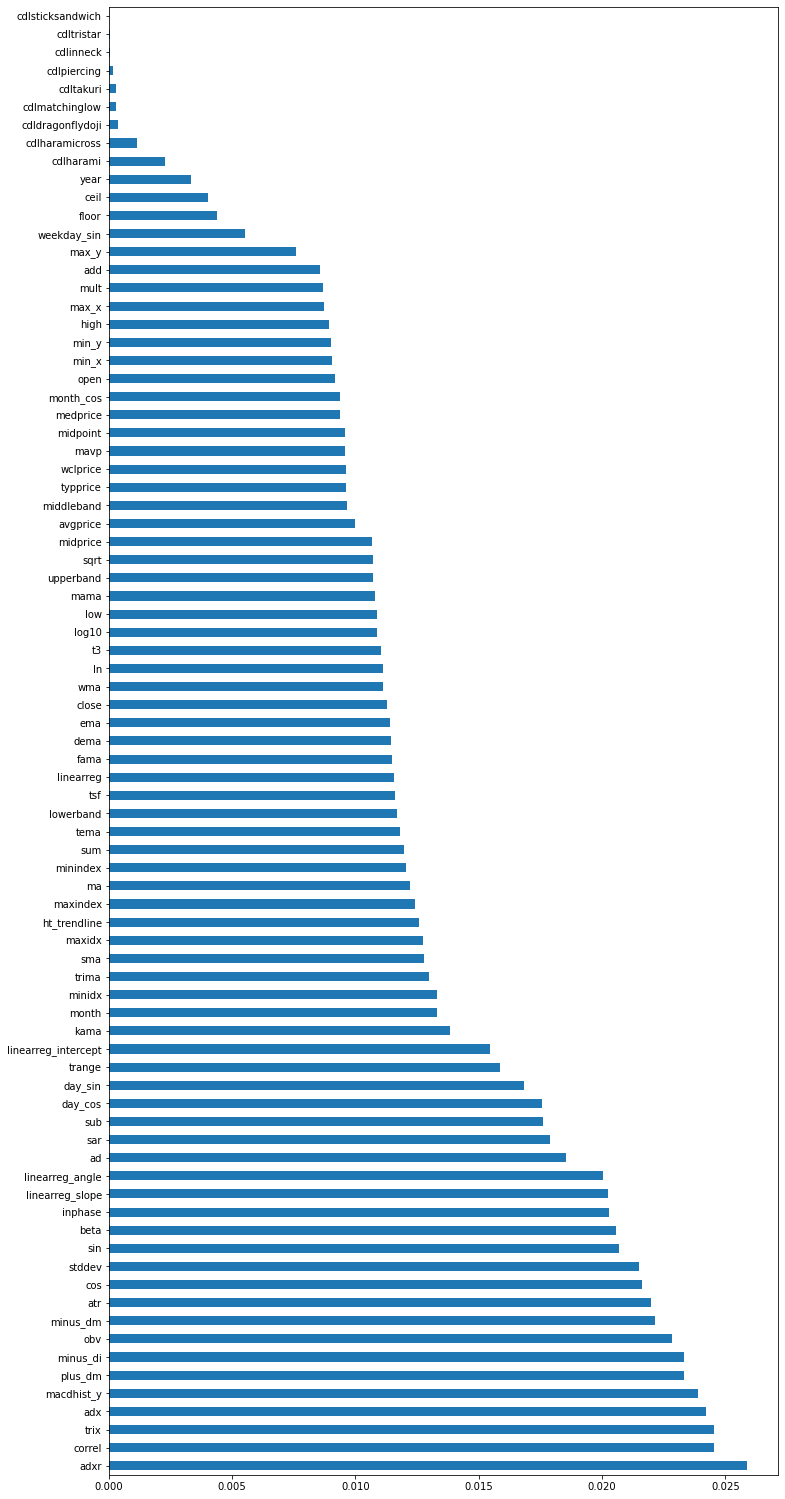

In [14]:
#feature importance using randomforest
x = selected_data.drop('target', axis=1)
y = selected_data.target
#split data for train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=3, 
                                                    shuffle=True)

#fit the model
model = rfc()
model.fit(train_x, train_y)

feature_importance = pd.Series(model.feature_importances_, index=selected_data.drop('target', axis=1).columns)
feature_importance.nlargest(len(selected_data)).plot(kind='barh', figsize=(12,27))

In [15]:
feature_importance.describe()

count    81.000000
mean      0.012346
std       0.006779
min       0.000000
25%       0.009176
50%       0.011443
75%       0.017554
max       0.025862
dtype: float64

In [16]:
#remove features with 0 importance
selected_data = selected_data[feature_importance[feature_importance > 0.00].index.to_list()]
selected_data.head()

,open,high,low,close,year,month,month_cos,day_sin,day_cos,weekday_sin,...,linearreg,linearreg_angle,linearreg_intercept,linearreg_slope,stddev,tsf,atr,trange,ad,obv
key_0,,,,,,,,,,,,,,,,,,,,,
1993-01-29,-0.998428,-0.998781,-0.997378,-0.998520,-1.0,-1.000000,0.866025,-0.209057,0.978148,-1.000000,...,-0.530466,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.896525,-1.000000,-0.902177
1993-02-01,-0.998428,-0.997998,-0.996766,-0.997649,-1.0,-0.818182,0.500000,0.209057,0.978148,-0.384043,...,-0.530466,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.990612,-0.999975,-0.902125
1993-02-02,-0.997729,-0.997649,-0.996329,-0.997388,-1.0,-0.818182,0.500000,0.408977,0.913545,0.725873,...,-0.530466,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.992970,-0.999967,-0.902103
1993-02-03,-0.997205,-0.996344,-0.995630,-0.996082,-1.0,-0.818182,0.500000,0.591023,0.809017,1.000000,...,-0.530466,0.11135,-0.526143,0.387379,-0.892286,-0.530549,-0.797849,-0.983539,-0.999944,-0.902045
1993-02-04,-0.995632,-0.995647,-0.995368,-0.995559,-1.0,-0.818182,0.500000,0.747238,0.669131,0.231914,...,-0.530466,0.11135,-0.526143,0.387379,-0.974900,-0.530549,-0.797849,-0.978824,-0.999924,-0.901987


In [17]:
#prepare train and test sets
final_data = selected_data
x = final_data
y = np.where(transformed_data.close.shift(-5) > transformed_data.close, 1, -1)
train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size=0.3, 
                                                    random_state=3, 
                                                    shuffle=True)

In [18]:
# #tune hyperparameters to get highest accuracy
# #uncomment to use
# accuracy = []
# parameter = np.linspace(1, 200, num=200, dtype='int')
# for n in parameter:
#     model = rfc(n_estimators=n, max_depth=38)
#     model.fit(train_x, train_y)
#     prediction = model.predict(test_x)
#     accuracy.append(model.score(test_x, test_y))
# pd.Series(accuracy,parameter).plot()
# print(pd.Series(accuracy,parameter).idxmax())

In [19]:
#perform prediction and show report
#default parameter also yield good accuracy
model = rfc(n_estimators=130, max_depth=38)
model.fit(train_x, train_y)
prediction = model.predict(test_x)
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

          -1       0.78      0.71      0.75       879
           1       0.81      0.86      0.84      1279

    accuracy                           0.80      2158
   macro avg       0.80      0.79      0.79      2158
weighted avg       0.80      0.80      0.80      2158



In [20]:
#save the model
#load the model and predict the whole dataset
#the new accuracy should be 0.7+0.3*previous accuracy
joblib.dump(model, "stock_movement_rfc.pkl") 
loaded_model = joblib.load("stock_movement_rfc.pkl")
new_prediction = loaded_model.predict(final_data)
print(classification_report(y, new_prediction))

              precision    recall  f1-score   support

          -1       0.94      0.92      0.93      2973
           1       0.94      0.96      0.95      4218

    accuracy                           0.94      7191
   macro avg       0.94      0.94      0.94      7191
weighted avg       0.94      0.94      0.94      7191

